# converting signals into images, bin files(.npz)

このノートブックではディレクトリを指定して、その中にある生波形データ(.mat)を、一括して画像(.png)及びその値（.npz）に変換し保存するという処理を行っています。

## シミュレーションデータ変換  
 シミュレーションで生成した`.mat`のファイルを統一形式である`.npz`に変換します。以下は、フォルダを指定するとその配下のファイルをすべて一括で変換し、`/processed`ディレクトリに保存するという処理を行うものです。

In [62]:
from src import mat2npz_sim
import os
import glob

# Define input and output directories
# Define the case name as a variable for clarity and reusability
case_name = "case16"

# Define base data directory for clarity
base_data_dir = "/home/smatsubara/documents/airlift/data/simulation"

def convert_all_simulation_mat_to_npz(case_name, base_data_dir):
    """
    Convert all simulation .mat files in the specified case directory to .npz format.

    Parameters
    ----------
    case_name : str
        The name of the simulation case (e.g., "case5").
    base_data_dir : str
        The base directory where simulation data is stored.
    """
    # Define input directory for raw simulation signals (relative to base_data_dir and case_name)
    mat_dir = os.path.join(base_data_dir, f"rawsignal/{case_name}/data")

    # Define config file path (relative to base_data_dir and case_name)
    config_path = os.path.join(base_data_dir, f"rawsignal/{case_name}/config.json")

    # Define output directory for processed files (relative to base_data_dir and case_name)
    output_dir = os.path.join(base_data_dir, f"processed/{case_name}")
    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")
    # Save a copy of the config.json file to the output directory for reference
    import shutil
    config_copy_path = os.path.join(output_dir, "config.json")
    shutil.copy2(config_path, config_copy_path)
    print(f"Copied config.json to: {config_copy_path}")

    # Create the output directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)
    mat_files_list = glob.glob(os.path.join(mat_dir, "*.mat"))
    for mat_file in mat_files_list:
        print(f"Processing: {mat_file}")
        mat2npz_sim(mat_file, config_path, output_dir)

# 関数の呼び出し例
convert_all_simulation_mat_to_npz(case_name, base_data_dir)




Created output directory: /home/smatsubara/documents/airlift/data/simulation/processed/case16
Copied config.json to: /home/smatsubara/documents/airlift/data/simulation/processed/case16/config.json
Processing: /home/smatsubara/documents/airlift/data/simulation/rawsignal/case16/data/solid_liquid_reflector2.mat
<KeysViewHDF5 ['#refs#', '#subsystem#', 'kgrid', 'sensor_data']>
['Nt', 'Nx', 'Ny', 'Nz', 'dim', 'dt', 'dx', 'dxudxn', 'dxudxn_sgx', 'dy', 'dyudyn', 'dyudyn_sgy', 'dz', 'dzudzn', 'dzudzn_sgz', 'k', 'k_max', 'kx_max', 'kx_vec', 'ky_max', 'ky_vec', 'kz_max', 'kz_vec', 'nonuniform', 'xn_vec', 'xn_vec_sgx', 'yn_vec', 'yn_vec_sgy', 'zn_vec', 'zn_vec_sgz']
999999999.9999999
keys: ['#refs#', '#subsystem#', 'kgrid', 'sensor_data']
['#refs#', '#subsystem#', 'kgrid', 'sensor_data']
(50000,)
Processed data and metadata saved to: /home/smatsubara/documents/airlift/data/simulation/processed/case16/solid_liquid_reflector2_processed.npz
Processing: /home/smatsubara/documents/airlift/data/simulati

## 機械学習用データセット生成（シミュレーション）
　次に、変換した`.npz`のファイルに対応する目標変数となる値を`/config.json`を使って計算し、データセットとなる`x_train.npy`,`t_train.npy`を作成していきます。これらのiDの紐づけが狂うとすべての計算の意味がなくなってしまうので、最大限注意してください。  
また、実機への展開をスムーズにするために、最大値を用いてスケーリングしていることとに注して下さい。その他順序付けなど筆者は細心の注意を払って実装していますが、もし誤りがあればご指摘いただけると幸いです。


In [ ]:
from src import calculate_gvf_and_signal,npz2png
import numpy as np
import math
import json
import glob
import os
#units are all mm
from src import process_case_and_return_dataset

x_list = []
t_list = []

# Define the base directory containing all cases
processed_base_dir = "/home/smatsubara/documents/airlift/data/simulation/processed"
output_path = "/home/smatsubara/documents/airlift/data/simulation/dataset"

# Get all case directories (e.g., case5, case6, ...)
case_dirs = sorted([d for d in os.listdir(processed_base_dir) if os.path.isdir(os.path.join(processed_base_dir, d)) and d.startswith("case")])

x_train_list = []
t_train_list = []

for case_name in case_dirs:
    base_dir = os.path.join(processed_base_dir, case_name)
    print(f"Processing {case_name} in {base_dir}")
    x_tmp, t_tmp = process_case_and_return_dataset(case_name, base_dir)
    print(f"x_tmp shape: {x_tmp.shape}, t_tmp shape: {t_tmp.shape}")
    x_train_list.append(x_tmp)
    t_train_list.append(t_tmp)
print("list done")
# Concatenate all cases into single arrays
x_train = np.concatenate(x_train_list, axis=0)
t_train = np.concatenate(t_train_list, axis=0)
x_train = x_train/np.max(x_train)
print("Final x_train shape:", x_train.shape)
print("Final t_train shape:", t_train.shape)
print(np.max(x_train),np.min(x_train))
np.save(os.path.join(output_path, "x_train.npy"), x_train)
np.save(os.path.join(output_path, "t_train.npy"), t_train)
#print(np.max(x_train))
#print(t_train)
#print(x_train)
npz_file_path = "/home/smatsubara/documents/airlift/data/simulation/processed/case4/solid_liquid7_processed.npz"
output_folder_path = "/home/smatsubara/documents/airlift/data/visualize"
npz2png(npz_file_path, output_folder_path, channel_index=0, start_time=0.0, end_time=None, full=True, pulse_index=0)
npz2png(npz_file_path, output_folder_path, channel_index=0, start_time=0.0, end_time=None, full=False, pulse_index=0)


## 実機データ変換  
実機データの`.mat`のファイルも、先ほどと同様に統一形式である`.npz`に変換します。同じく、`experiments/processed`に保存されるようにしています。

In [1]:
from src import mat2npz_exp,npz2png
import os

import glob

# Get all .mat files in the rawsignal directory
rawsignal_dir = "/home/smatsubara/documents/airlift/data/experiments/rawsignal"
output_dir = "/home/smatsubara/documents/airlift/data/experiments/processed"
visualize_dir = "/home/smatsubara/documents/airlift/data/visualize"
mat_files = glob.glob(os.path.join(rawsignal_dir, "*.mat"))
path_tmp = "/home/smatsubara/documents/airlift/data/experiments/rawsignal/P20241018-1530.mat"
processed_path_tmp ="/home/smatsubara/documents/airlift/data/experiments/processed/P20241018-1530_processed.npz"
# # Run mat2npz_exp for each .mat file
mat2npz_exp(
        file_path=path_tmp,
        output_dir=output_dir,
        start_time=0,  #初期の信号は不安定であることが多いため除外
        duration=5.0,
        amplitude_threshold=2,
        window_width=0.1e-3,
        signal_key="TDX1"
    )
npz2png(file_path=processed_path_tmp,save_path=visualize_dir,full=False,pulse_index=0)


Loading data...
Loading successful
Using device: cuda
Number of detected triggers: (14988,)
arranged_pulses.shape: (14988, 5208, 4)
convert_exp finished
max: inf
processed_data.shape: (14000, 2500, 4)
max: inf
processed_data[0,:,0].shape: (2500,)
max: 1.0998042821884155
argmax: 329
maxes argmax: 3,max: 3.4028234663852886e+38
(14000, 1, 4) 0.04892368 3.4028235e+38
scaled: ((14000, 2500, 4), -3.4028235e+38, 3.4028235e+38)
max_value: 3.4028234663852886e+38
['__header__', '__version__', '__globals__', 'Tstart', 'Tinterval', 'ExtraSamples', 'RequestedLength', 'Length', 'Version', 'TDX1', 'TDX2', 'TDX3', 'TDX1_enlarged']
signal points: (2500,)
Processed data and metadata saved to: /home/smatsubara/documents/airlift/data/experiments/processed/P20241018-1530_processed.npz
processed_data.shape:(14000, 2500, 4)
/home/smatsubara/documents/airlift/data/visualize/P20241018-1530_processed_1pulse.png


## 機械学習用データセット生成(実機)  
次に、変換した`.npz`のファイルに対応する目標変数となる値を`/target_variables.csv`を使って参照し、データセット`x_test.npy` `t_test.npy`を作成していきます。


In [39]:
import polars as pl

# CSVファイルをUTF-8 (BOM付き) で読み込むことで文字化けを防ぐ
target_variables = pl.read_csv(
    '/home/smatsubara/documents/airlift/data/experiments/target_valiables.csv',
    encoding="SHIFT_JIS"
)
print(target_variables.head())

# 既存の"IDXX"列が重複して作成されるのを防ぐため、まず"IDXX"列が存在すれば削除する
if "IDXX" in target_variables.columns:
    target_variables = target_variables.drop("NAME")

# "IDXX"列を新たに作成
# 1列目・2列目のカラム名を取得
date_col = target_variables.columns[0]
time_col = target_variables.columns[1]
target_variables = target_variables.with_columns(
    (pl.lit("P") + pl.col(date_col).cast(pl.Utf8) + "-" + pl.col(time_col).cast(pl.Utf8)).alias("NAME")
)

# 表示用のカラムリストを作成（重複がないようにする）
cols_to_show = [col for col in target_variables.columns[2:] if col != "NAME"] + ["NAME"]

# 結果を表示
print(target_variables.select(cols_to_show))
from src import mat2npz_exp


import glob

# Get all .mat files in the rawsignal directory
rawsignal_dir = "/home/smatsubara/documents/airlift/data/experiments/rawsignal"
output_dir = "/home/smatsubara/documents/airlift/data/experiments/processed"

mat_files = glob.glob(os.path.join(rawsignal_dir, "*.mat"))

# Run mat2npz_exp for each .mat file
for file_path in mat_files:
    print(f"Processing {file_path}")
    mat2npz_exp(
        file_path=file_path,
        output_dir=output_dir,
        start_time=0.1,  #初期の信号は不安定であることが多いため除外
        duration=5.0,
        amplitude_threshold=2,
        window_width=0.1e-3,
        signal_key="TDX1"
    )


shape: (5, 9)
┌──────────┬──────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ 日付     ┆ 時分 ┆ 固相見かけ ┆ 気相見かけ ┆ … ┆ 固相体積率 ┆ 気相体積率 ┆ 液相体積率 ┆ ガラス球  │
│ ---      ┆ ---  ┆ 流速       ┆ 流速       ┆   ┆ ---        ┆ ---        ┆ ---        ┆ 直径      │
│ i64      ┆ i64  ┆ ---        ┆ ---        ┆   ┆ f64        ┆ f64        ┆ f64        ┆ ---       │
│          ┆      ┆ f64        ┆ f64        ┆   ┆            ┆            ┆            ┆ str       │
╞══════════╪══════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ 20240726 ┆ 1022 ┆ 0.0        ┆ 31.922755  ┆ … ┆ 0.0        ┆ 0.749158   ┆ 0.250842   ┆ -         │
│ 20240726 ┆ 1055 ┆ 0.0        ┆ 32.685636  ┆ … ┆ 0.0        ┆ 0.745521   ┆ 0.254479   ┆ -         │
│ 20240726 ┆ 1113 ┆ 0.0        ┆ 32.048131  ┆ … ┆ 0.0        ┆ 0.7546132  ┆ 0.2453868  ┆ -         │
│ 20240726 ┆ 1122 ┆ 0.0        ┆ 31.968982  ┆ … ┆ 0.0        ┆ 0.742794   ┆ 0.257206   ┆ -         │
│ 20240726 ┆ 13

## 参考：機械学習
では、簡単なモデルでこのデータセットを学習し、実機で性能を検証してみましょう。

tensor(1.)
torch.Size([120, 2500])
torch.Size([120, 1])


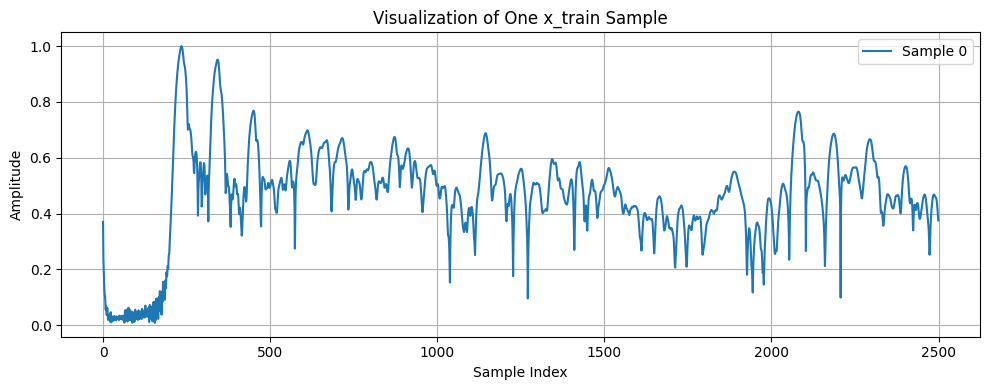

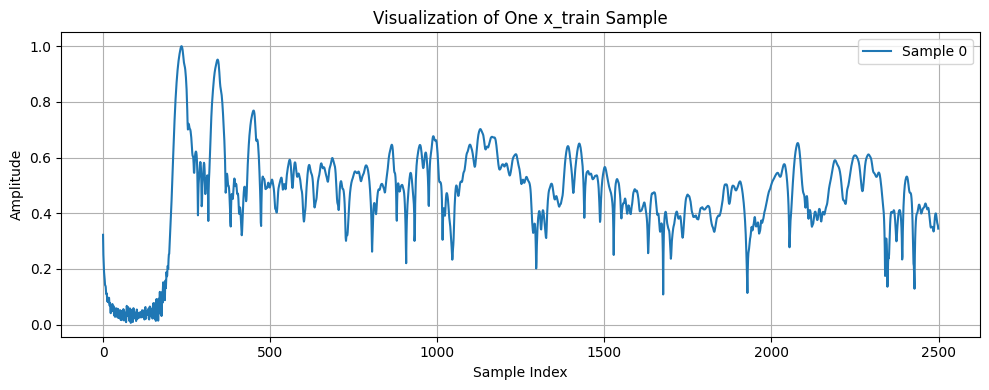

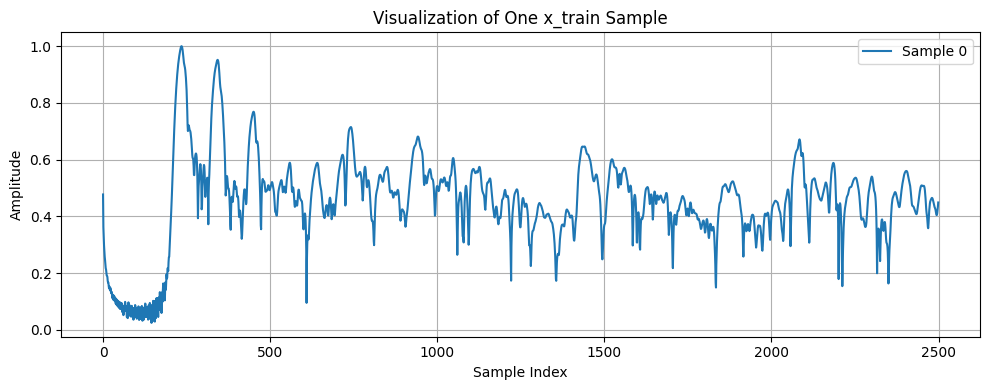

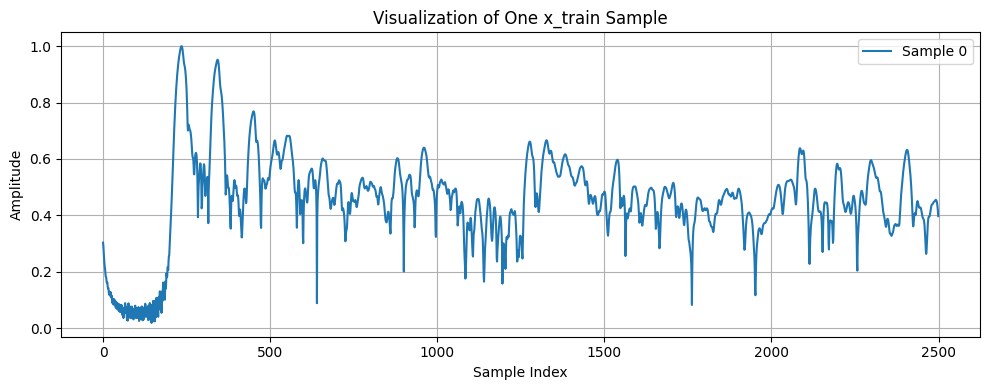

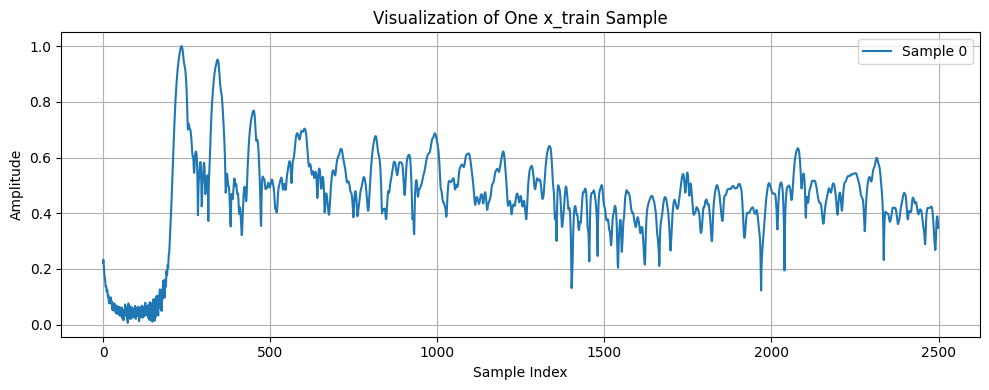

Using device: cuda:1
torch.Size([120])
torch.Size([120, 2500])
torch.Size([120, 1, 2500])
torch.Size([120])
2500


In [4]:
import numpy as np
import torch
x_train = np.load('/home/smatsubara/documents/airlift/data/simulation/dataset/x_train.npy')
t_train = np.load('/home/smatsubara/documents/airlift/data/simulation/dataset/t_train.npy')

x_train_tensor = torch.from_numpy(x_train).float()
t_train_tensor = torch.from_numpy(t_train).float()
if t_train_tensor.ndim == 1:
    t_train_tensor = t_train_tensor.unsqueeze(-1)
if x_train_tensor.ndim == 1:
    x_train_tensor = x_train_tensor.unsqueeze(-1)
print(torch.max(x_train_tensor))
print(x_train_tensor.shape)
print(t_train_tensor.shape)
#print(t_train_tensor)
import matplotlib.pyplot as plt

def plot_x_train(x_train,index):
    plt.figure(figsize=(10, 4))
    plt.plot(x_train[index], label="Sample 0")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.title("Visualization of One x_train Sample")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
for i in range(5):
    plot_x_train(x_train,i)
# Basic GPyTorch regression tutorial with a simple sine function dataset

import math
import torch
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(23)

# English comment: Set device to GPU cuda:1 if available, otherwise CPU
if torch.cuda.device_count() > 1:
    device = torch.device("cuda:1")
    print("Using device: cuda:1")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using device: cuda:0")
else:
    device = torch.device("cpu")
    print("Using device: cpu")

# Convert numpy arrays to torch tensors and move to device
# GPyTorch expects float32 tensors
t_train_tensor = torch.from_numpy(t_train).float().to(device)
x_train_tensor = torch.from_numpy(x_train).float().to(device)
print(t_train_tensor.shape)
print(x_train_tensor.shape)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Check if x_train_tensor is 2D (samples, features) or needs reshaping for CNN
# For 1D CNN, input should be (batch, channels, length)
# If x_train_tensor is (N, L), reshape to (N, 1, L)
if x_train_tensor.ndim == 2:
    x_train_tensor_cnn = x_train_tensor.unsqueeze(1)  # (N, 1, L)
else:
    # If already 3D, use as is
    x_train_tensor_cnn = x_train_tensor

# If t_train_tensor is 2D, flatten to 1D for regression
if t_train_tensor.ndim > 1 and t_train_tensor.shape[1] == 1:
    t_train_tensor_cnn = t_train_tensor.squeeze(1)
else:
    t_train_tensor_cnn = t_train_tensor
print(x_train_tensor_cnn.shape)
print(t_train_tensor_cnn.shape)
# Create TensorDataset and DataLoader
from torch.utils.data import random_split

dataset = TensorDataset(x_train_tensor_cnn, t_train_tensor_cnn)
total_size = len(dataset)
train_size = int(0.75 * total_size)
val_size = total_size - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
batch_size=8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# Get input length from data
input_length = x_train_tensor_cnn.shape[2]
print(input_length)

In [2]:
import torch.nn as nn
device = torch.device("cuda:0")
# Define a simple 1D CNN model for regression with proper normalization
class SimpleCNN(nn.Module):
    def __init__(self, input_length):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=301, padding=1)
        # English comment: Use BatchNorm1d for normalization after the first convolution
        self.bn1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(16, 4, kernel_size=301, padding=1)
        # English comment: Use BatchNorm1d for normalization after the second convolution
        self.bn2 = nn.BatchNorm1d(4)
        self.relu2 = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(4, 1)

    def forward(self, x):
        # x: (batch, 1, length)
        x = self.conv1(x)
        x = self.bn1(x)  # English comment: Apply batch normalization after the first convolution
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)  # English comment: Apply batch normalization after the second convolution
        x = self.relu2(x)
        x = self.pool(x)  # (batch, 8, 1)
        x = x.view(x.size(0), -1)  # (batch, 8)
        x = self.fc(x)  # (batch, 1)
        return x.squeeze(1)  # (batch,)


size=2500
# Instantiate model, loss, and Aoptimizer, and move model to device
model = SimpleCNN(size).to(device)

In [5]:

# English comment: Define a custom loss function as the sum of (target - prediction) / target
def relative_sum_loss(pred, target):
    # English comment: Take the logarithm of the loss to avoid instability due to very small values
    epsilon = 1e-7  # Avoid division by zero and log(0)
    # 英語でコメント: Calculate the mean of the relative error instead of the sum
    loss = torch.mean(torch.abs(target - pred) / (target + epsilon))
    #loss = torch.log(torch.abs(loss) + epsilon)
    return loss

#criterion = relative_sum_loss
criterion = nn.MSELoss()
# English comment: Initialize the Adam optimizer with a learning rate of 1e-4 for the model parameters
optimizer = optim.Adam(params=model.parameters(), lr=1.2e-3)

# Training loop

# Save the learning curve as an image
import matplotlib.pyplot as plt

loss_history = []

num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_x.size(0)
    epoch_loss = running_loss / len(train_dataloader.dataset)
    loss_history.append(epoch_loss)
    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
save_path="/home/smatsubara/documents/sandbox/psdata2matlab/tmp"
import os
# Plot and save the learning curve (logarithmic loss)
plt.figure()
# English comment: Plot the logarithm of the loss values for each epoch
plt.plot(range(1, num_epochs + 1), [np.log(l) for l in loss_history])
plt.title('Learning Curve (Log Loss)')
plt.xlabel('Epoch')
plt.ylabel('Log(Loss)')
plt.grid(True)
plt.savefig(os.path.join(save_path, 'learning_curve_log.png'))
plt.close()

# Plot and save the learning curve (raw loss)
plt.figure()
# English comment: Plot the raw loss values for each epoch
plt.plot(range(1, num_epochs + 1), loss_history)
plt.title('Learning Curve (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(os.path.join(save_path, 'learning_curve.png'))
plt.close()


torch.save(model.state_dict(), os.path.join(save_path, 'model.pth'))


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0! (when checking argument for argument weight in method wrapper_CUDA__cudnn_convolution)

### 推論  
学習したモデルを用いて、検証用のデータセットで性能を評価します。検証用の入力データをモデルに流し、どのような出力が得られるのかを確認しましょう。  
なおメモリが足りないので学習はcuda:1で、推論はcuda:0で行います。それゆえ、データ転送を行っていることに注意してください。また、学習済のモデルをロードしていることに注意してください。これにより、どの環境においても推論を行うソフトウェアを構築することが可能となります。

/tmp/ipykernel_4037781/3615995921.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(save_path, 'model.pth')))


Validation predictions shape: torch.Size([30])
Validation targets shape: torch.Size([30])
tensor([0.0753, 0.0503, 0.0916, 0.0546, 0.1000, 0.0411, 0.0762, 0.0703, 0.0562,
        0.0477, 0.0806, 0.0794, 0.0601, 0.0243, 0.0816, 0.0200, 0.0353, 0.0514,
        0.0497, 0.0359, 0.0321, 0.0582, 0.0810, 0.0760, 0.0792, 0.0240, 0.0746,
        0.0745, 0.0375, 0.0527])
Pearson correlation coefficient between predictions and actual values: 0.8884


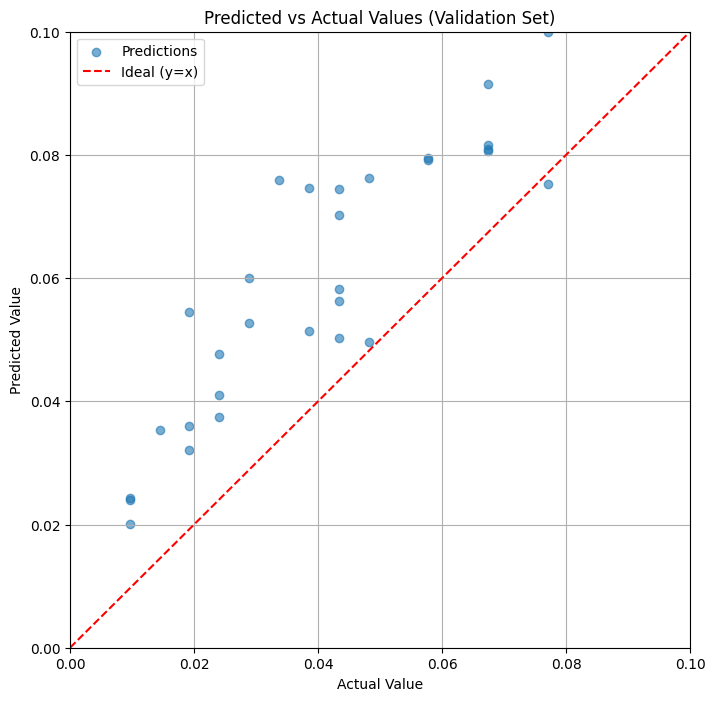

/tmp/ipykernel_4037781/3615995921.py:74: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


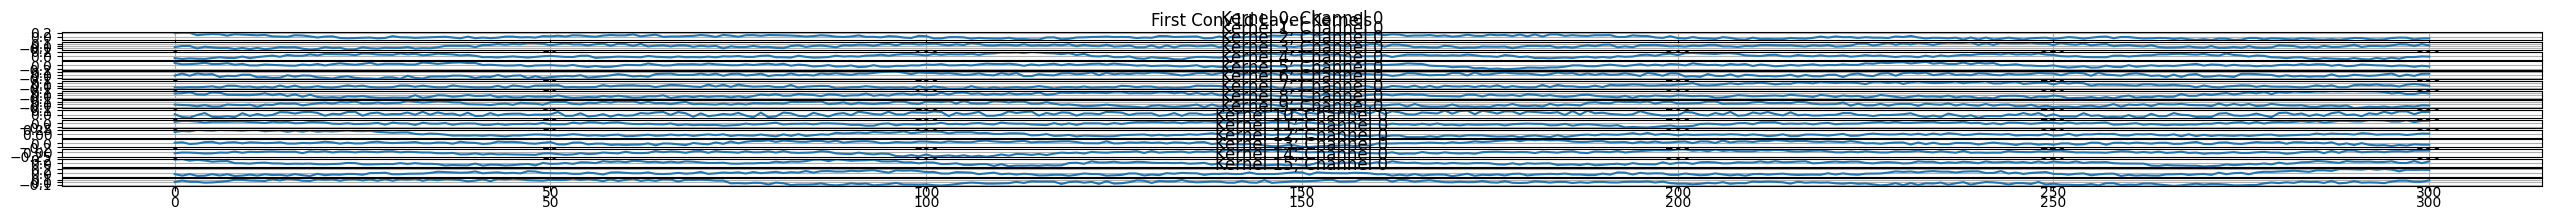

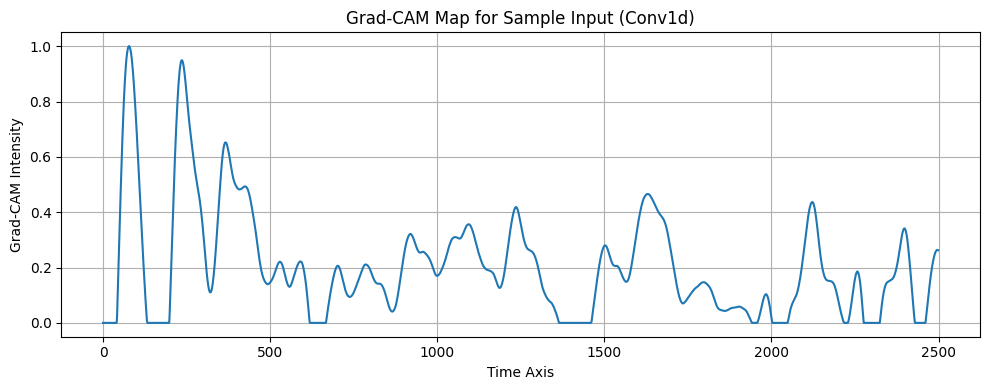

In [11]:
import os
save_path="/home/smatsubara/documents/sandbox/psdata2matlab/tmp"
model.load_state_dict(torch.load(os.path.join(save_path, 'model.pth')))
model = model.to('cuda:0')
model.eval()
val_predictions = []
val_targets = []
with torch.no_grad():
    for val_x, val_y in val_dataloader:
        # English comment: Send both val_x and val_y to cuda:0 for inference
        val_x = val_x.to('cuda:0')
        val_y = val_y.to('cuda:0')
        outputs = model(val_x)
        val_predictions.append(outputs.cpu())
        val_targets.append(val_y.cpu())
val_predictions = torch.cat(val_predictions, dim=0)
val_targets = torch.cat(val_targets, dim=0)
print("Validation predictions shape:", val_predictions.shape)
print("Validation targets shape:", val_targets.shape)
print(val_predictions)
# English comment: Plot the validation predictions and targets for comparison
import matplotlib.pyplot as plt

# English comment: Calculate the correlation coefficient between predicted and actual values
import numpy as np

# Convert tensors to numpy arrays
val_targets_np = val_targets.numpy().flatten()
val_predictions_np = val_predictions.numpy().flatten()

# English comment: Compute the Pearson correlation coefficient
correlation_matrix = np.corrcoef(val_targets_np, val_predictions_np)
correlation_coefficient = correlation_matrix[0, 1]
print(f"Pearson correlation coefficient between predictions and actual values: {correlation_coefficient:.4f}")

# English comment: Plot predicted values (y-axis) against actual values (x-axis) in the xy-plane, with both axes limited to the range [0, 1]
plt.figure(figsize=(8, 8))
plt.scatter(val_targets_np, val_predictions_np, alpha=0.6, marker='o', label='Predictions')
plt.plot([0, 1], [0, 1], 'r--', label='Ideal (y=x)')
plt.title('Predicted vs Actual Values (Validation Set)')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_path, 'val_pred_vs_actual_scatter.png'))
plt.show()
# English comment: Visualize the kernels (filters) of the first convolutional layer and compute Grad-CAM for a sample input

# --- Visualize kernels of the first convolutional layer (Conv1d version) ---
# English comment: Get the first Conv1d layer (assuming model has attribute 'conv1' or similar)
first_conv1d = None
for m in model.modules():
    if isinstance(m, torch.nn.Conv1d):
        first_conv1d = m
        break

if first_conv1d is not None:
    kernels = first_conv1d.weight.data.cpu().numpy()  # shape: (out_channels, in_channels, kernel_size)
    num_kernels = kernels.shape[0]
    num_channels = kernels.shape[1]
    kernel_size = kernels.shape[2]
    plt.figure(figsize=(num_kernels * 2, 2 * num_channels))
    for i in range(num_kernels):
        for j in range(num_channels):
            plt.subplot(num_kernels, num_channels, i * num_channels + j + 1)
            # English comment: Show the 1D kernel as a line plot
            plt.plot(kernels[i, j, :])
            plt.title(f'Kernel {i}, Channel {j}')
            plt.axis('tight')
            plt.grid(True)
    plt.suptitle('First Conv1d Layer Kernels')
    plt.tight_layout()
    plt.show()
else:
    print("No Conv1d layer found in the model.")

# --- Grad-CAM visualization for Conv1d ---
# English comment: Define a simple Grad-CAM function for the last Conv1d layer
class GradCAM1d:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            # English comment: For regression, use the output directly
            target = output.squeeze()
        else:
            target = output[:, class_idx]
        # English comment: For regression, backward on the sum
        if target.ndim > 0:
            target = target.sum()
        target.backward(retain_graph=True)
        gradients = self.gradients  # shape: (batch, channels, length)
        activations = self.activations  # shape: (batch, channels, length)
        # English comment: Global average pooling over the time dimension
        weights = gradients.mean(dim=2, keepdim=True)  # shape: (batch, channels, 1)
        grad_cam_map = (weights * activations).sum(dim=1, keepdim=True)  # shape: (batch, 1, length)
        grad_cam_map = torch.relu(grad_cam_map)
        grad_cam_map = torch.nn.functional.interpolate(grad_cam_map, size=input_tensor.shape[2], mode='linear', align_corners=False)
        grad_cam_map = grad_cam_map.squeeze().cpu().numpy()
        grad_cam_map = (grad_cam_map - grad_cam_map.min()) / (grad_cam_map.max() - grad_cam_map.min() + 1e-8)
        return grad_cam_map

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

# English comment: Find the last Conv1d layer for Grad-CAM
target_layer_1d = None
for m in reversed(list(model.modules())):
    if isinstance(m, torch.nn.Conv1d):
        target_layer_1d = m
        break

if target_layer_1d is not None:
    grad_cam_1d = GradCAM1d(model, target_layer_1d)
    # English comment: Use a sample from validation set for Grad-CAM
    # val_x shape: (batch, channels, length)
    sample_input = val_x[0].unsqueeze(0).to('cuda:0')
    grad_cam_map = grad_cam_1d(sample_input)
    grad_cam_1d.remove_hooks()
    # English comment: Plot the Grad-CAM heatmap (1D)
    plt.figure(figsize=(10, 4))
    plt.plot(grad_cam_map)
    plt.title('Grad-CAM Map for Sample Input (Conv1d)')
    plt.xlabel('Time Axis')
    plt.ylabel('Grad-CAM Intensity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No Conv1d layer found for Grad-CAM.")


(14000, 2500)
max: 1.1819961071014404
max: 1.513253927230835
torch.Size([14000, 1, 2500])
max_values_per_column.shape: torch.Size([14000, 1, 1])
torch.Size([14000, 1, 2500])
max: 0.6931471824645996


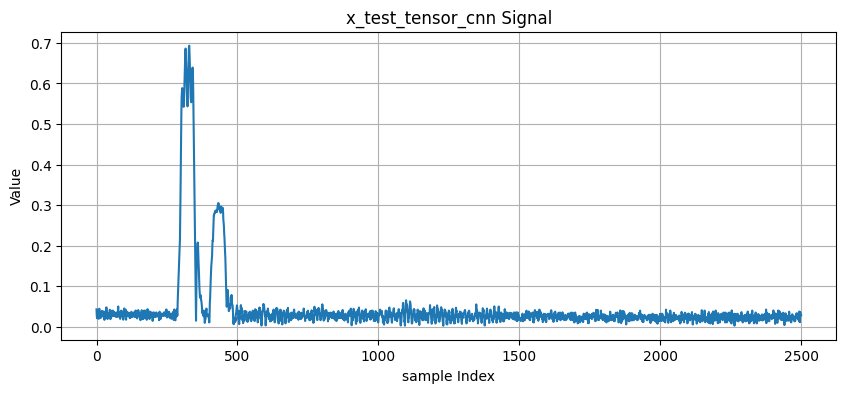

torch.Size([2500])
predictions.shape: torch.Size([14000])
tensor([0.1263, 0.1264, 0.1264,  ..., 0.1257, 0.1255, 0.1257], device='cuda:0')
tensor(0.1258, device='cuda:0') tensor(1.1410e-07, device='cuda:0')


In [7]:
import numpy as np
import torch
from scipy.signal import hilbert
from src import mat2npz_exp,npz2png,hilbert_cuda,preprocess_and_predict
path1 = "/home/smatsubara/documents/airlift/data/experiments/processed/P20241004-1600_processed.npz"
path2 = "/home/smatsubara/documents/airlift/data/experiments/processed/P20241007-1112_processed.npz"
path3 = "/home/smatsubara/documents/airlift/data/experiments/processed/P20241008-1047_processed.npz"
path4 = "/home/smatsubara/documents/airlift/data/experiments/processed/P20241010-1427_processed.npz"
output_folder_path = "/home/smatsubara/documents/sandbox/psdata2matlab/tmp"

# 例: 使用例
mean,var = preprocess_and_predict(path3, model)
    


### 推論②  
実機データに関する推論を行います。このプロセスにおける重要な特徴として、実機データは５秒間、すなわち15000回分の測定が記録されています。それゆえ、一回分の測定に基づき相体積率を推定するこのモデルを15000回適用し、その時間方向の平均をとるという手法をとっています。

In [ ]:
import polars as pl
from src import preprocess_and_predict
# CSVファイルをUTF-8 (BOM付き) で読み込むことで文字化けを防ぐ
target_variables = pl.read_csv(
    '/home/smatsubara/documents/airlift/data/experiments/target_valiables.csv',
    encoding="SHIFT_JIS"
)
print(target_variables.head())
output_folder_path = "/home/smatsubara/documents/airlift/data/tmp" 
# 既存の"IDXX"列が重複して作成されるのを防ぐため、まず"IDXX"列が存在すれば削除する
if "IDXX" in target_variables.columns:
    target_variables = target_variables.drop("NAME")

# "IDXX"列を新たに作成
# 1列目・2列目のカラム名を取得
date_col = target_variables.columns[0]
time_col = target_variables.columns[1]
target_variables = target_variables.with_columns(
    (pl.lit("P") + pl.col(date_col).cast(pl.Utf8) + "-" + pl.col(time_col).cast(pl.Utf8)).alias("NAME")
)

# 表示用のカラムリストを作成（重複がないようにする）
cols_to_show = [col for col in target_variables.columns[2:] if col != "NAME"] + ["NAME"]

# Add a new column "FullPath" next to "NAME" that contains the full path to the corresponding processed file
processed_dir = "/home/smatsubara/documents/airlift/data/experiments/processed"
target_variables = target_variables.with_columns(
    (pl.lit(processed_dir + "/") + pl.col("NAME") + pl.lit("_processed.npz")).alias("FullPath")
)

# "FullPath"が正しいことが確認できたので、各パスからデータを読み込み、モデルで推論し、mean, varを新しいカラムとして追加する
import os

mean_list = []
var_list = []

for row in target_variables.iter_rows(named=True):
    file_path = row["FullPath"]
    # Debug: Check if the file path is exactly as expected
    if file_path == "/home/smatsubara/documents/airlift/data/experiments/processed/P20241015-1037_processed.npz":
        print("DEBUG: File path matches exactly:", file_path)
        print("DEBUG: File exists:", os.path.exists(file_path))
    if os.path.exists(file_path):
        try:
            mean, var = preprocess_and_predict(file_path, model)
            mean_list.append(mean)
            var_list.append(var)
        except Exception as e:
            # Even if the file exists, an error occurred during preprocess_and_predict.
            # The most common reasons are:
            # - The file format is not as expected (e.g., missing keys, wrong structure)
            # - The file is corrupted or empty
            # - preprocess_and_predict expects certain data inside the .npz file, but it is not present
            # - The model or preprocessing code is not compatible with the data
            # - There is a bug in preprocess_and_predict or the model
            # To debug, print the exception:
            print("ERROR: Exception occurred while processing:", file_path)
            print("Exception message:", str(e))
            mean_list.append(None)
            var_list.append(None)
    else:
        mean_list.append(None)
        var_list.append(None)

# 新しいカラムとして追加
# mean_list, var_listはfloatまたはNoneのみを含むようにし、"Not Found"はNoneに置き換えた
target_variables = target_variables.with_columns([
    pl.Series("mean", mean_list, dtype=pl.Float64),
    pl.Series("var", var_list, dtype=pl.Float64)
])

# "FullPath"の直後に"mean"と"var"が来るようにカラム順を調整
cols_to_show = [col for col in target_variables.columns[2:] if col not in ["NAME", "FullPath", "mean", "var"]] + ["NAME", "FullPath", "mean", "var"]
save_csv_path = "/home/smatsubara/documents/airlift/data/experiments"
save_path = os.path.join(save_csv_path, "predicted.csv")
target_variables.select(cols_to_show).write_csv(save_path)
print(f"予測結果を {save_path} に保存しました。")

# 結果を表示
#print(target_variables.select(cols_to_show))


### 可視化  
データが複数ありますので、一度に推論をすべて終わらせることは計算機の制約上できません。そこで、実機データを一つずつ読み込んで推論、それを平均し.csvに記入します。そして、それをプロットするという体制をとります。これによりスペックの低いマシンを有効活用できます。

shape: (5, 11)
┌─────────────┬─────────────┬─────────────┬────────────┬───┬────────────┬────────────┬──────┬──────┐
│ 固相見かけ  ┆ 気相見かけ  ┆ 液相見かけ  ┆ 固相体積率 ┆ … ┆ NAME       ┆ FullPath   ┆ mean ┆ var  │
│ 流速        ┆ 流速        ┆ 流速        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---  ┆ ---  │
│ ---         ┆ ---         ┆ ---         ┆ f64        ┆   ┆ str        ┆ str        ┆ f64  ┆ f64  │
│ f64         ┆ f64         ┆ f64         ┆            ┆   ┆            ┆            ┆      ┆      │
╞═════════════╪═════════════╪═════════════╪════════════╪═══╪════════════╪════════════╪══════╪══════╡
│ 0.0         ┆ 31.922755   ┆ 6.059601    ┆ 0.0        ┆ … ┆ P20240726- ┆ /home/smat ┆ null ┆ null │
│             ┆             ┆             ┆            ┆   ┆ 1022       ┆ subara/doc ┆      ┆      │
│             ┆             ┆             ┆            ┆   ┆            ┆ uments/air ┆      ┆      │
│             ┆             ┆             ┆            ┆   ┆            ┆ …          ┆      ┆      │
│

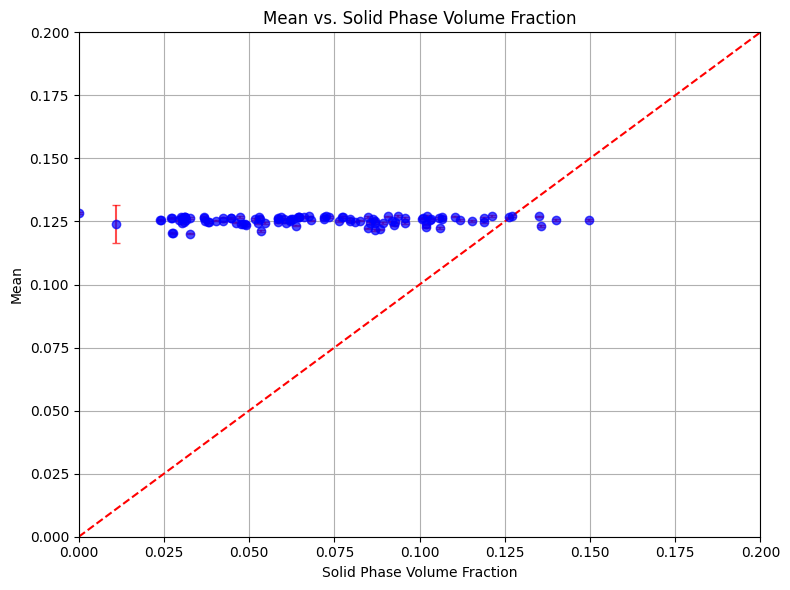

In [12]:
import polars as pl
import numpy as np
# CSVファイルをUTF-8 (BOM付き) で読み込むことで文字化けを防ぐ
target_variables = pl.read_csv(
    '/home/smatsubara/documents/airlift/data/experiments/predicted.csv',
    #encoding="SHIFT_JIS"
)
print(target_variables.head())
import matplotlib.pyplot as plt

# 英語コメント: Plot mean (y-axis) vs. solid phase volume fraction (x-axis)
x = target_variables["固相体積率"].to_numpy()
y = target_variables["mean"].to_numpy()
#bias = 0.2*np.ones(len(y))
#y = y - bias
print(y)
yerr = target_variables["var"].to_numpy() ** 0.5
# Calculate the correlation coefficient between x and y
# Remove any NaN values before calculation
import numpy as np

# Remove NaN values from x, y pairs
mask = ~np.isnan(x) & ~np.isnan(y)
x_valid = x[mask]
y_valid = y[mask]

if len(x_valid) > 1:
    corr_coef = np.corrcoef(x_valid, y_valid)[0, 1]
    print(f"Correlation coefficient between x and y: {corr_coef:.4f}")
else:
    print("Not enough valid data to calculate correlation coefficient.")

plt.figure(figsize=(8, 6))
plt.errorbar(x, y, yerr=yerr, fmt='o', color='blue', alpha=0.7, ecolor='red', capsize=3)
plt.plot([0, 1], [0, 1], 'r--', label='Ideal (y=x)')
plt.xlabel("Solid Phase Volume Fraction")
plt.ylabel("Mean")
plt.xlim(0, 0.2)
plt.ylim(0, 0.2)
plt.title("Mean vs. Solid Phase Volume Fraction")
plt.grid(True)
plt.tight_layout()
plt.show()
